# Peer-graded Assignment: Эксперименты с моделью



## Инструкции

1\. Начнем с простого. Оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Построем кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратим внимание на `sklearn.model_selection.learning_curve`

In [1]:
#analyse
import pandas as pd
import numpy as np


# prepare data
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils import shuffle
from sklearn import manifold

#processing
from sklearn.pipeline import Pipeline


#Quality control
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#Models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,linear_model, preprocessing, ensemble, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



#scaller
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

#encoder
import category_encoders as ce
from category_encoders.cat_boost import CatBoostEncoder

#fill nan
from sklearn.impute import SimpleImputer


## visualise
import seaborn as sns
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
path='/Users/nikli/Documents/git_reps/Data/'
churn_data = pd.read_csv(path+'orange_small_churn_data.txt')
churn_label = pd.read_csv(path+'orange_small_churn_labels.txt',names = ['Labels'])

In [3]:
# удаление неинформативных фич
# Неинформативными считаю фичи, в которых одно константное значение 
def dropUninformative(data):
    data=data.copy()
    df = pd.DataFrame([])
    for i in range(data.shape[1]):
        if len(data.iloc[:,i].unique())>1:
            df["Var"+str(i)] = data.iloc[:,i]
    return df

In [4]:
def main_prepare(data,last_numeric_cols,last_label_cols):
    for col in  range(last_numeric_cols):
        data[data.columns[col]] = data.iloc[:,col].fillna(0).astype('float')
    for col in  range(last_numeric_cols,last_label_cols):    #for col in  range(190,230): 
        data[data.columns[col]] = data.iloc[:,col].fillna('0').astype('string')
    return data

def labelEncoder(data,start_label_col,end_label_col):
    data = data.fillna('0')
    le = preprocessing.LabelEncoder()
    
    
    for m in range(start_label_col,end_label_col):
        data.iloc[:,m] = data.apply(lambda col: le.fit_transform(data.iloc[:,m].astype(str)), axis=0, result_type='expand')

        
    return data

def main_prepare_and_encode(data, last_numeric_cols,last_label_cols):
    data = main_prepare(data,last_numeric_cols,last_label_cols)

    data = labelEncoder(data,last_numeric_cols,last_label_cols)
    return data
    
churn_data=main_prepare_and_encode(churn_data, 190, 230)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [6]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    print(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Learning Curves (RandomForestClassifier)


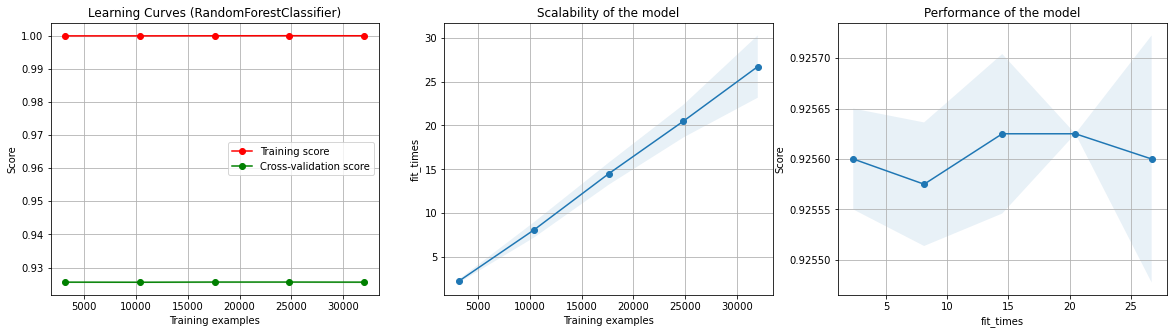

In [13]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X=churn_data
y=churn_label

title = r"Learning Curves (RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = ensemble.RandomForestClassifier()

plot_learning_curve(estimator,
                    title, X, y,
#                     axes=axes[:, 1],
#                     ylim=(0.7, 1.01),
#                     cv=cv,
                    n_jobs=4)

plt.show()


In [14]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 3)

In [9]:
from sklearn.model_selection import learning_curve
import xgboost as xgb
train_sizes_abs, train_scores, test_scores = learning_curve(xgb.XGBClassifier(), X, y, cv = skf,
                                                            scoring = 'roc_auc')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.figure()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color = 'r', label = 'Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.legend(loc = 'best')
plt.show()

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Зададим веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуем не менее трёх различных вариантов весов.Узнаем, меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [10]:
X_train=churn_data
y_train=churn_label
### Оценка качества модели без весов

skf = StratifiedKFold(n_splits = 3)
scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring = 'roc_auc', cv = skf)
print('Без весов: ', scores.mean())


Без весов:  0.5339853671993698


In [10]:
sample_weight1 = np.array([1 if x == -1 else 5 for x in y_train.Labels])
sample_weight2 = np.array([1 if x == -1 else 10 for x in y_train.Labels])
sample_weight3 = np.array([1 if x == -1 else 15 for x in y_train.Labels])
for sample_weight in sample_weight1, sample_weight2, sample_weight3:
    scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring = 'roc_auc', cv = skf,
                             fit_params = {'sample_weight': sample_weight})
    print( scores.mean())

0.5551216493394234
0.5712963049410918
0.5662091409041498


### Вывод: для линейных моделей можно увеличивать значение редкого класса,чтобы придать важности

2.2\. Применим к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуем не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [35]:
X

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,0.0,...,0,3696,1,0,0,14,0,29,0,0
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,0.0,...,4,347,1,0,1,22,2,2,2,0
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,0.0,...,6,2498,1,0,0,7,3,25,2,0
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,0.0,...,4,2602,1,0,0,22,2,8,0,0
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,0.0,...,4,1375,1,0,0,12,2,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,0.0,0.0,0.0,0.0,938.0,7.0,0.0,0.0,0.0,...,4,505,1,0,2,7,2,8,2,0
39996,0.0,0.0,0.0,0.0,0.0,1750.0,7.0,0.0,0.0,0.0,...,4,2062,1,0,0,12,2,8,0,0
39997,0.0,0.0,0.0,0.0,0.0,1204.0,7.0,0.0,0.0,0.0,...,4,3305,1,0,1,12,2,8,1,0
39998,0.0,0.0,0.0,0.0,0.0,8232.0,14.0,0.0,0.0,0.0,...,4,2037,1,0,0,20,2,8,0,0


In [15]:
def undersampling(data, labels,col_to_label):
    from sklearn.utils import shuffle

    data['Labels']=labels
    dataChurn = data[data['Labels'] == 1]
    
    dataNoChurn = data[data['Labels'] == -1]
    
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:col_to_label], dataChurn.iloc[:,col_to_label:]
X_undersampled , y_undersampled = undersampling(X, y, 230)


In [17]:
def compare_2_dataframe(x_1, y_1, x_2, y_2, title_1, title_2):
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    #title = "Usual Data"
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    estimator1 = LogisticRegression()
    plot_learning_curve(estimator1, title_1, x_1, y_1, axes=axes[:, 0], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=4)
    
    #title = "Undersampled Data"
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    estimator2 = LogisticRegression()
    plot_learning_curve(estimator2, title_2, x_2 , y_2, axes=axes[:, 1], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=4)

    plt.show()
    
    
compare_2_dataframe(x_1=X, y_1=y,
                    x_2=X_undersampled,y_2=y_undersampled, 
                    title_1="Usual Data", title_2="Undersampled Data")  

In [52]:
### Для линейных моделей размер выборки имеет значение!

3\. Теперь перейдем к работе с признаками. Ранее мы реализовали несколько стратегий для обработки пропущенных значений. Сравним эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [18]:
churn_data = pd.read_csv(path+'orange_small_churn_data.txt')
churn_label = pd.read_csv(path+'orange_small_churn_labels.txt',names = ['Labels'])
#churn_data=main_prepare_and_encode(churn_data, 190, 230)
churn_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


### Чтобы сравнить методы замены пропусков - подготовим датасет:


In [20]:
### Удалим признаки, которые состоят полностью из nan значений
churn_data=dropUninformative(churn_data)
churn_data['Labels']=churn_label
churn_data.head()

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Labels
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,-1


In [21]:
churn_data.columns[160:]

Index(['Var175', 'Var176', 'Var177', 'Var178', 'Var179', 'Var180', 'Var181',
       'Var182', 'Var183', 'Var185', 'Var186', 'Var187', 'Var188', 'Var189',
       'Var190', 'Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var209', 'Var210', 'Var211',
       'Var212', 'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225',
       'Var226', 'Var227', 'Var228', 'Labels'],
      dtype='object')

In [22]:
cat_cols=['Var190','Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196','Var197',
          'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203','Var204',
          'Var205', 'Var206', 'Var207', 'Var209', 'Var210', 'Var211','Var212', 
          'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218','Var219',
          'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225','Var226',
          'Var227', 'Var228']
#churn_data.iloc[:,1]
## закодируем категориалььные признаки
churn_data[cat_cols] = ce.CatBoostEncoder().fit_transform(churn_data[cat_cols], churn_data['Labels'])
churn_data

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Labels
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,-0.851200,-0.851200,-0.925600,-0.925600,-0.851200,-0.851200,-0.851200,-0.851200,-0.851200,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,-0.851200,-0.851200,-0.950400,-0.950400,-0.925600,-0.851200,-0.851200,-0.851200,-0.925600,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,-0.925600,-0.851200,-0.962800,-0.962800,-0.950400,-0.925600,-0.925600,-0.851200,-0.925600,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,-0.283733,-0.851200,-0.570240,-0.570240,-0.462800,-0.851200,-0.283733,0.074400,-0.283733,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,NaN,NaN,NaN,NaN,NaN,938.0,7.0,NaN,NaN,NaN,...,-0.837393,-0.585120,-0.850584,-0.850558,-0.862933,-0.810349,-0.833708,-0.826758,-0.889917,-1
39996,NaN,NaN,NaN,NaN,NaN,1750.0,7.0,NaN,NaN,NaN,...,-0.837398,-0.865700,-0.850589,-0.850562,-0.824767,-0.853427,-0.833713,-0.826765,-0.822694,-1
39997,NaN,NaN,NaN,NaN,NaN,1204.0,7.0,NaN,NaN,NaN,...,-0.837404,-0.866168,-0.850594,-0.850566,-0.895420,-0.853471,-0.833719,-0.826771,-0.887871,-1
39998,NaN,NaN,NaN,NaN,NaN,8232.0,14.0,NaN,NaN,NaN,...,-0.837409,-0.784068,-0.850599,-0.850569,-0.824776,-0.876120,-0.833725,-0.826778,-0.822702,-1


In [1]:
test_data=churn_data.copy()

#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#test_data.loc[:,:] = imputer.fit_transform(test_data.loc[:,:])


In [24]:
### Теперь мы можем тестировать способы кодирования данных:
def fill_na(train_data,  strategy="mean"):
    train_data=train_data.copy()
    if strategy=="mean":
        imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)

    if strategy=='median':
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    if strategy=='most_frequent':
        imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    if strategy=='0':
        train_data=train_data.fillna(0)
        
        y=train_data['Labels'] 
        x=train_data.drop('Labels', axis=1)

        ## Делим на обучение и тест
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

        model = LogisticRegression()

        model.fit(X_train, y_train)

        preds_class = model.predict(X_test)

        f1 = f1_score(y_test, preds_class, average='macro')

        print(f1)
        return 'Done!'


    train_data.loc[:,:] = imputer.fit_transform(train_data.loc[:,:])
    
    y=train_data['Labels'] 
    x=train_data.drop('Labels', axis=1)

    ## Делим на обучение и тест
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)
    
    model = xgb.XGBClassifier()

    model.fit(X_train, y_train)
    
    preds_class = model.predict(X_test)
    
    f1 = f1_score(y_test, preds_class, average='macro')
    
    print(f1)
    
fill_na(test_data,  strategy="mean")
fill_na(test_data,  strategy="median")
fill_na(test_data,  strategy="most_frequent")
fill_na(test_data,  strategy="0")

0.4864923399593236
0.48753560650378114
0.48872489612188363
0.48944687101562645


'Done!'

### Вывод: замена пропущенных значений на 0 даёт лучшчий скор!

4\. Также мы уже реализовали несколько стратегий для обработки категориальных признаков. Сравним эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [7]:
## Загружаем датасет
churn_data = pd.read_csv(path+'orange_small_churn_data.txt')
churn_label = pd.read_csv(path+'orange_small_churn_labels.txt',names = ['Labels'])

churn_data=dropUninformative(churn_data)
churn_data['Labels']=churn_label
churn_data=churn_data.fillna(0)

churn_data.head()

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Labels
0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,0.0,...,Al6ZaUT,vr93T2a,LM8l689qOp,0,0,fKCe,02N6s8f,xwM2aC7IdeMC0,0,-1
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,0.0,...,oslk,6hQ9lNX,LM8l689qOp,0,ELof,xb3V,RAYp,55YFVY9,mj86,-1
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,0.0,...,zCkv,catzS2D,LM8l689qOp,0,0,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,-1
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,0.0,...,oslk,e4lqvY0,LM8l689qOp,0,0,xb3V,RAYp,F2FyR07IdsN7I,0,1
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,0.0,...,oslk,MAz3HNj,LM8l689qOp,0,0,WqMG,RAYp,F2FyR07IdsN7I,0,-1


In [22]:
def cat_coding(train_data, method):
    train_data=train_data.copy()
    ## method=Dummy
    if method=='dummy':
        #train_data=pd.get_dummies(train_data)
        return 'НЕ ДЕЛАЙ OHE если у тебя много категориальных переменных!!!!'
    
    
    else:
        cols=train_data.loc[:,'Var190':'Var228'].columns
        if method=='frequency':
            for col in cols:
                freq_encode = train_data.groupby(col).size() / train_data.shape[0]
                train_data.loc[:, col] = train_data[col].map(freq_encode)
                
            train_data= train_data
         
        
        elif method=='mean':
            for col in cols:
                mean_encode = train_data.groupby(col)['Labels'].mean() # Считаем среднее значение таргета группиря по нашему столбцу
                train_data.loc[:, col] = train_data[col].map(mean_encode)
            train_data= train_data 
                
        
        elif method=='smoothed':
            for col in cols:
                mean = train_data['Labels'].mean() # Находим среднее значение
                agg = train_data.groupby(col)['Labels'].agg(['count', 'mean']) # Считаем среднее значение и число повторов значения столбца
                counts = agg['count']
                means = agg['mean']
                weight = 100
                smooth = (counts * means + weight * mean) / (counts + weight)
                train_data.loc[:, col] = train_data[col].map(smooth)
                train_data= train_data
                
        
        elif method=='WOE':#Weight of Evidence encoding | считаем ln отношения вероятностей принадлежности к классам
                
            WOEE_encoder = ce.WOEEncoder()
            print(train_data.isna().sum().sum())
            print(np.any(np.isnan(train_data)))
            train_data.loc[:,'Var190':'Var228'] = WOEE_encoder.fit_transform(train_data.loc[:,'Var190':'Var228'],
                                                                             train_data['Labels'])
            train_data= train_data
        
                
        elif method=='leave_one_out':#Leave-one-out encoding | Считает среднее значение таргета для случая, когда пример удален из дата-сета.
            LOOE_encoder = ce.LeaveOneOutEncoder()
            train_data.loc[:,'Var190':'Var228'] = LOOE_encoder.fit_transform(train_data.loc[:,'Var190':'Var228'],
                                                                             train_data['Labels'])
            train_data=train_data
    
            
        elif method=='сatboost':
            CBE_encoder = CatBoostEncoder()
            train_data.loc[:,'Var190':'Var228'] = CBE_encoder.fit_transform(train_data.loc[:,'Var190':'Var228'],
                                                                             train_data['Labels'])
            train_data= train_data
        
    y=train_data['Labels'] 
    x=train_data.drop('Labels', axis=1)

    ## Делим на обучение и тест
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

    model = LogisticRegression()

    model.fit(X_train, y_train)

    preds_class = model.predict(X_test)

    f1 = f1_score(y_test, preds_class, average='macro')

    print(f1)
    pass
    
        
    
# cat_coding(churn_data,  method="dummy")
cat_coding(churn_data,  method="frequency")
cat_coding(churn_data,  method="mean")
cat_coding(churn_data,  method="smoothed")
# cat_coding(churn_data,  method="WOE")  # Value Error should check the problem
cat_coding(churn_data,  method="leave_one_out")
cat_coding(churn_data,  method="сatboost")


0.48954852281798805
0.48941302599839187
0.4893792003361963
0.48944687101562645
0.48944687101562645


### Вывод: Лучший метод - frequency. Выражаем признак через его частоту

5\. Проведём процедуру отбора признаков, попробуйте разные варианты отбора (обратим внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`).  Попробуем как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели?

In [55]:
# Таким способом можно будет удалять признаки с нулевой дисперсией
from sklearn.feature_selection import SelectKBest

# from sklearn.feature_selection import VarianceThreshold 
# X_train_vt = VarianceThreshold().fit_transform(X_train)

churn_data = pd.read_csv(path+'orange_small_churn_data.txt')
churn_label = pd.read_csv(path+'orange_small_churn_labels.txt',names = ['Labels'])

churn_data=dropUninformative(churn_data)
churn_data['Labels']=churn_label
churn_data=churn_data.fillna(0)

cols=churn_data.loc[:,'Var190':'Var228'].columns
for col in cols:
    freq_encode = churn_data.groupby(col).size() / churn_data.shape[0]
    churn_data.loc[:, col] = churn_data[col].map(freq_encode)
    
train_data=churn_data.copy()

y=train_data['Labels'] 
x=train_data.drop('Labels', axis=1)

## Делим на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

In [34]:
skf = StratifiedKFold(n_splits = 3)

X_f_classif = SelectKBest(k = len(X_train.columns)).fit_transform(X_train, y_train)
scores = cross_val_score(xgb.XGBClassifier(), X_f_classif, y_train, scoring = 'roc_auc', cv = skf)
print('ANOVA F-value: ', scores.mean())

ANOVA F-value:  0.7388488522979229


In [33]:
X_f_classif = SelectKBest(k = 90).fit_transform(X_train, y_train)
scores = cross_val_score(xgb.XGBClassifier(), X_f_classif, y_train, scoring = 'roc_auc', cv = skf)
print('ANOVA F-value: ', scores.mean())

ANOVA F-value:  0.7411789989555889


In [32]:
X_f_classif = SelectKBest(k = 40).fit_transform(X_train, y_train)
X_test_classif=SelectKBest
scores = cross_val_score(xgb.XGBClassifier(), X_f_classif, y_train, scoring = 'roc_auc', cv = skf)
print('ANOVA F-value: ', scores.mean())

ANOVA F-value:  0.742451891708825


In [36]:
X_f_classif = SelectKBest(k = 35).fit_transform(X_train, y_train)
scores = cross_val_score(xgb.XGBClassifier(), X_f_classif, y_train, scoring = 'roc_auc', cv = skf)
print('ANOVA F-value: ', scores.mean())

ANOVA F-value:  0.7415070648190231


### Вывод, уменьшение признаков увеличивает качество модели - большая часть признаков оказались неинформативными!


6\. Подберём оптимальные параметры модели. Обратим внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмём наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `optuna`) Как подбор параметров повлиял на качество модели?

In [44]:
import optuna
import sklearn

def objective(trial):

    classifier = trial.suggest_categorical('classifier', ['XGBoost'])
    
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    gamma=trial.suggest_float('gamma', 0.01, 0.1)
    learning_rate=trial.suggest_float('learning_rate', 0.00001, 2)
    max_depth=trial.suggest_int('max_depth',3, 24)
    colsample_bytree=trial.suggest_float('colsample_bytree', 0.60, 0.98)
    reg_lambda=trial.suggest_int('reg_lambda', 1, 20, log=True)

    clf = XGBClassifier(n_estimators=n_estimators,
                                gamma=gamma,
                                learning_rate=learning_rate,
                                )
    return sklearn.model_selection.cross_val_score(
        clf, X_f_classif, y_train, n_jobs=-1, cv=4).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-01-15 03:05:32,847] A new study created in memory with name: no-name-934047a5-680f-42ff-8238-6d7d1dcbb95c
[I 2021-01-15 03:05:38,068] Trial 0 finished with value: 0.8973214285714286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 9, 'gamma': 0.0643007061759077, 'learning_rate': 1.9369570377681802, 'max_depth': 12, 'colsample_bytree': 0.7808542842867876, 'reg_lambda': 1}. Best is trial 0 with value: 0.8973214285714286.
[I 2021-01-15 03:05:39,071] Trial 1 finished with value: 0.92525 and parameters: {'classifier': 'XGBoost', 'n_estimators': 13, 'gamma': 0.07341117504080158, 'learning_rate': 0.14642654041231515, 'max_depth': 15, 'colsample_bytree': 0.728501022359169, 'reg_lambda': 1}. Best is trial 1 with value: 0.92525.
[I 2021-01-15 03:05:40,058] Trial 2 finished with value: 0.92525 and parameters: {'classifier': 'XGBoost', 'n_estimators': 11, 'gamma': 0.03685394252966972, 'learning_rate': 0.09558528488696934, 'max_depth': 8, 'colsample_bytree': 0.6197232779949928, 're

[I 2021-01-15 03:05:58,953] Trial 24 finished with value: 0.9245000000000001 and parameters: {'classifier': 'XGBoost', 'n_estimators': 8, 'gamma': 0.047166365813602465, 'learning_rate': 0.910190799282462, 'max_depth': 23, 'colsample_bytree': 0.9772920756259221, 'reg_lambda': 16}. Best is trial 10 with value: 0.9256428571428571.
[I 2021-01-15 03:05:59,875] Trial 25 finished with value: 0.9224642857142857 and parameters: {'classifier': 'XGBoost', 'n_estimators': 11, 'gamma': 0.010387769486673517, 'learning_rate': 1.2226915028840821, 'max_depth': 17, 'colsample_bytree': 0.930129599103764, 'reg_lambda': 9}. Best is trial 10 with value: 0.9256428571428571.
[I 2021-01-15 03:06:00,501] Trial 26 finished with value: 0.9253571428571429 and parameters: {'classifier': 'XGBoost', 'n_estimators': 3, 'gamma': 0.01815031708826647, 'learning_rate': 0.5381387160738724, 'max_depth': 24, 'colsample_bytree': 0.7453588699182672, 'reg_lambda': 5}. Best is trial 10 with value: 0.9256428571428571.
[I 2021-01-

Accuracy: 0.9256428571428571
Best hyperparameters: {'classifier': 'XGBoost', 'n_estimators': 7, 'gamma': 0.01728174027148935, 'learning_rate': 0.620295165652943, 'max_depth': 23, 'colsample_bytree': 0.8387860909193084, 'reg_lambda': 19}


In [58]:
selector = SelectKBest(k=40)
selector.fit(X_train, y_train)

X_train_ = selector.transform(X_train)
X_test_ = selector.transform(X_test)


In [56]:
clf = XGBClassifier(n_estimators=trial.params['n_estimators'],
                    gamma=trial.params['gamma'],
                    learning_rate=trial.params['learning_rate'],
                    max_depth=trial.params['max_depth'],
                    colsample_bytree=trial.params['colsample_bytree'],
                    reg_lambda=trial.params['reg_lambda']
                                )

clf.fit(X_train, y_train)

preds_class = clf.predict(X_test)

f1 = f1_score(y_test, preds_class, average='macro')

print(f1)

0.5028694801719842


In [59]:
clf = XGBClassifier(n_estimators=trial.params['n_estimators'],
                    gamma=trial.params['gamma'],
                    learning_rate=trial.params['learning_rate'],
                    max_depth=trial.params['max_depth'],
                    colsample_bytree=trial.params['colsample_bytree'],
                    reg_lambda=trial.params['reg_lambda']
                                )

clf.fit(X_train_, y_train)

preds_class = clf.predict(X_test_)

f1 = f1_score(y_test, preds_class, average='macro')

print(f1)

0.4991141637007471


In [ ]:
# def grid_search_cv(model,X_train, Y_train, params):
    
    
    
#     g = GridSearchCV(estimator=model(random_state=0),
#                      param_grid=params,
#                      cv=3, n_jobs=-1, verbose=1)

#     g.fit(X_train, Y_train)
#     print(f'Best score: {g.best_score_}')
#     print(f'Best params: {g.best_params_}')
    
    
# param_grid_DT={'max_depth': list(range(1, 5)) + [None],
#                              'max_features': ['sqrt', 'log2', None],
#                              'class_weight': [None, 'balanced']
#                              }

# grid_search_cv(model = DecisionTreeClassifier,
#               X_train=train_data_upd,
#               Y_train=y,
#               params=param_grid_DT)


# Best score: 0.6097585790904202
# Best params: {'class_weight': None, 'max_depth': 4, 'max_features': None}

7\. Предложим методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируем, какие признаки внесли больший вклад в модель, а какие меньший?

1. Можно посмотреть,какие признаки оставила модель KBest. 
2. Можно посмотреть на корреляцию с целевой меткой 
3. Можно посмотреть на веса обученной модели

8\. Напоследок посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположим, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [65]:
print(selector.get_support(indices=True))
train_df=pd.DataFrame(X_train_,columns=selector.get_support(indices=True))
test_df=pd.DataFrame(X_test_,columns=selector.get_support(indices=True))
train_df

[  6  11  24  54  61  62  63  69  70 101 114 123 128 131 140 172 175 176
 177 181 182 183 185 188 189 190 192 193 194 196 199 200 202 203 204 207
 208 209 210 211]


,6,11,24,54,61,62,63,69,70,101,...,199,200,202,203,204,207,208,209,210,211
0,0.0,0.0,233.44,9.0,0.0,22.0,0.0,214119.00,0.0,-242921.20,...,0.000025,0.506325,0.000675,0.740250,0.000675,0.523375,0.023225,0.70280,0.655275,0.569425
1,0.0,0.0,220.08,9.0,3.0,18.0,0.0,398814.00,0.0,80184.80,...,0.000025,0.506325,0.002525,0.740250,0.002525,0.523375,0.055750,0.70280,0.655275,0.569425
2,21.0,2432.0,207.52,36.0,9.0,36.0,1071.0,215119.50,0.0,-178735.60,...,0.000050,0.506325,0.000050,0.061075,0.000050,0.523375,0.055750,0.04545,0.655275,0.569425
3,0.0,0.0,286.96,9.0,3.0,30.0,0.0,113561.70,0.0,132293.20,...,0.000675,0.479675,0.001450,0.740250,0.001450,0.523375,0.052925,0.70280,0.655275,0.569425
4,7.0,1116.0,233.44,18.0,0.0,84.0,0.0,32881.80,0.0,16268.72,...,0.000450,0.479675,0.000900,0.740250,0.000900,0.207225,0.028175,0.70280,0.655275,0.232800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,220.08,9.0,0.0,20.0,0.0,17089.95,0.0,21427.44,...,0.000025,0.479675,0.000625,0.740250,0.000625,0.523375,0.059350,0.70280,0.655275,0.569425
27996,14.0,140.0,202.00,27.0,9.0,50.0,14.0,35530.50,0.0,588788.00,...,0.002200,0.479675,0.001225,0.740250,0.001225,0.207225,0.023100,0.70280,0.655275,0.196250
27997,7.0,1932.0,200.00,9.0,0.0,178.0,63.0,12659.19,0.0,-18421.56,...,0.000100,0.479675,0.088925,0.740250,0.088925,0.207225,0.042300,0.12320,0.024950,0.196250
27998,0.0,0.0,233.44,0.0,0.0,56.0,0.0,224149.50,0.0,-205236.40,...,0.000525,0.479675,0.000450,0.740250,0.000450,0.523375,0.084650,0.70280,0.655275,0.196250


In [66]:
data_with_predict = test_df
data_with_predict['labels'] = y_test

data_with_predict['predicted'] = preds_class
data_with_predict['probability'] = clf.predict_proba(X_test_)[:,0]


In [68]:
# возвращает объекты, на которых совершены ошибки первого и второго рода
# параметры thresh_1 и thresh_2 - пороги для объектов, на которых модель совершила наибольшую ошибку
def errorObjects(data, thresh_1, thresh_2):
    df_first_type_err = pd.DataFrame([])
    df_second_type_err = pd.DataFrame([])
    for sample in range(len(data)):
        if (data['labels'][sample] == 1.0) and (data['predicted'][sample] == -1.0):
            if abs(1-data['probability'][sample]) > thresh_1:
                df_first_type_err = df_first_type_err.append(data.loc[sample])
        if (data['labels'][sample] == -1.0) and (data['predicted'][sample] == 1.0):
            if abs(data['probability'][sample]) > thresh_2:
                df_second_type_err = df_second_type_err.append(data.loc[sample])
    print( 'size of first type error samples: ' + str(len(df_first_type_err)))
    print( 'size of second type error samples: ' + str(len(df_second_type_err)))
    return(df_first_type_err, df_second_type_err)

In [93]:
def featureImportance(estimator, data):
    fig = plt.figure(figsize=(20, 70))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(estimator.feature_importances_, columns=["importance"])
    df_f["labels"] = data.columns.values
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(40))

    index = np.arange(40)
    bar_width = 0.5
    rects = plt.barh(index , df_f["importance"][:40], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.show()
    return df_f


,importance,labels
10,0.103585,114
6,0.077713,63
23,0.048726,188
28,0.044668,194
15,0.039409,172
18,0.035170,177
26,0.034366,192
24,0.032148,189
39,0.030186,211
30,0.028682,199


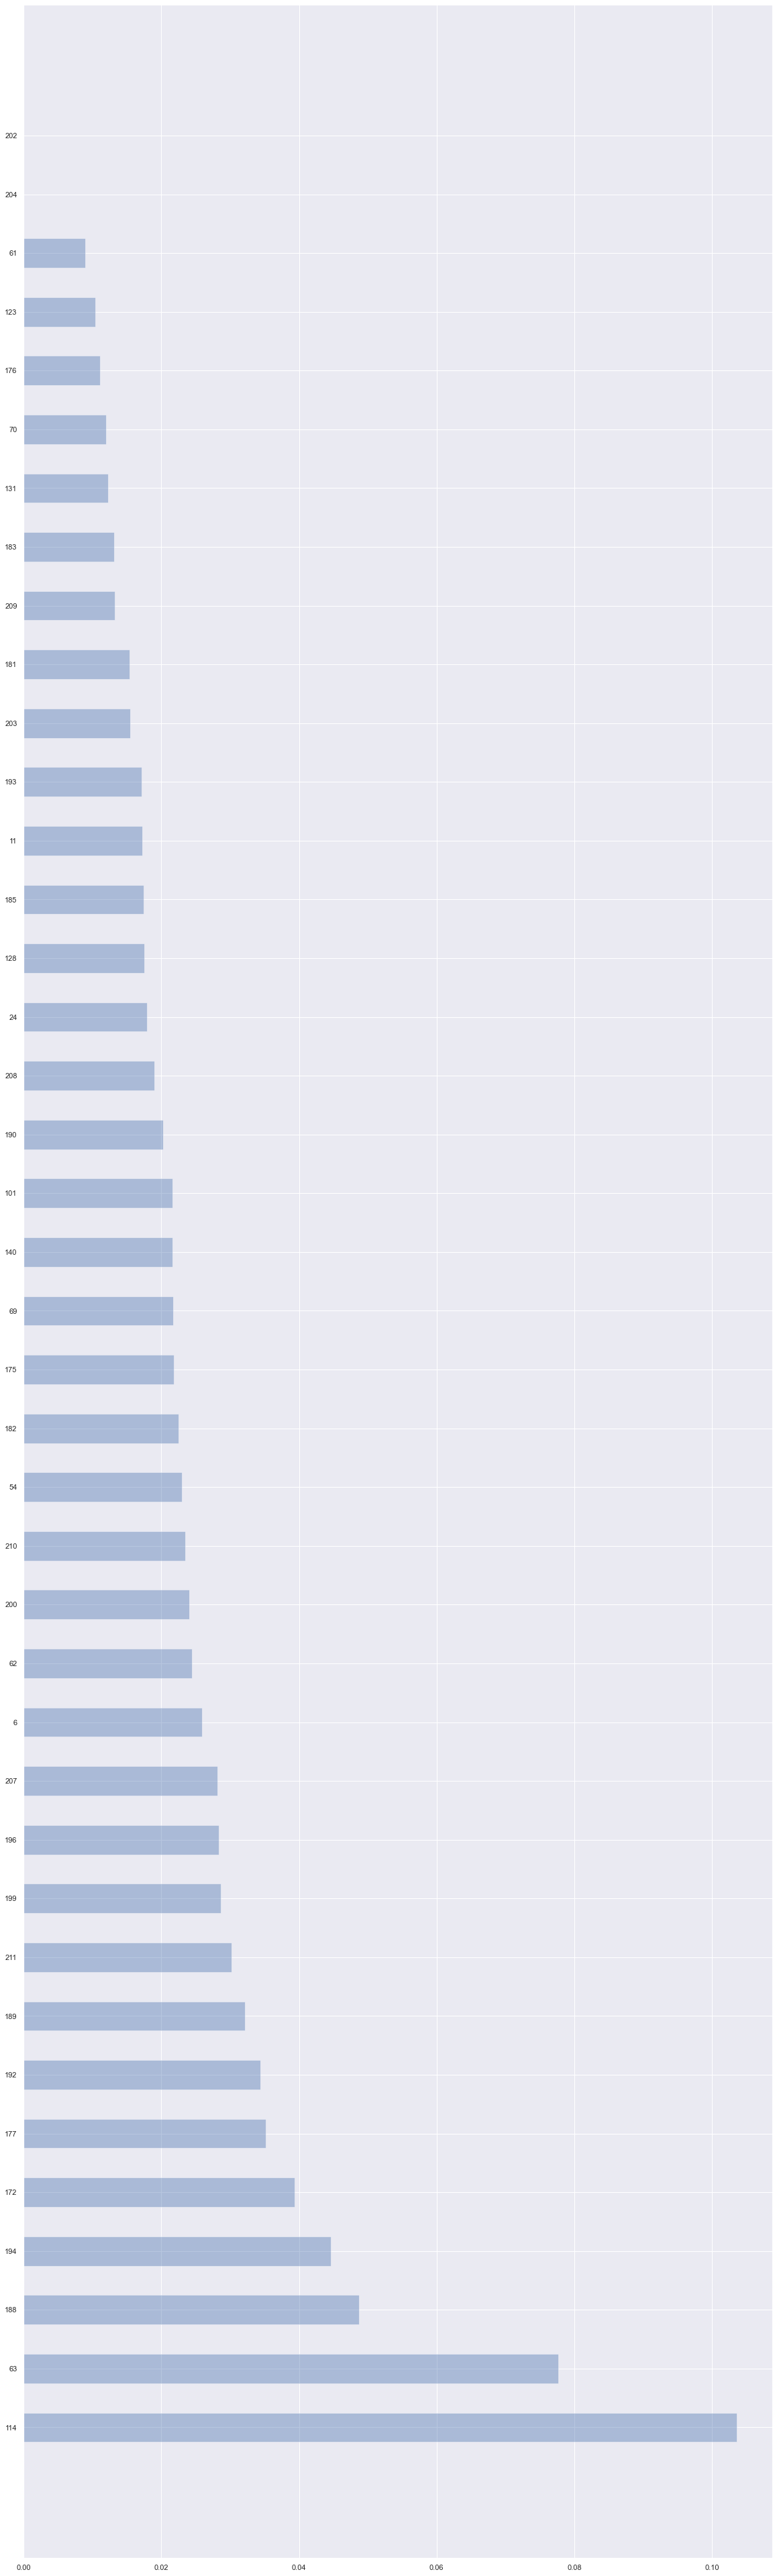

In [96]:
important_features = featureImportance(clf, train_df)


In [77]:
first_type_err, second_type_err = errorObjects(data_with_predict, 0.3, 0.001)

size of first type error samples: 4
size of second type error samples: 9


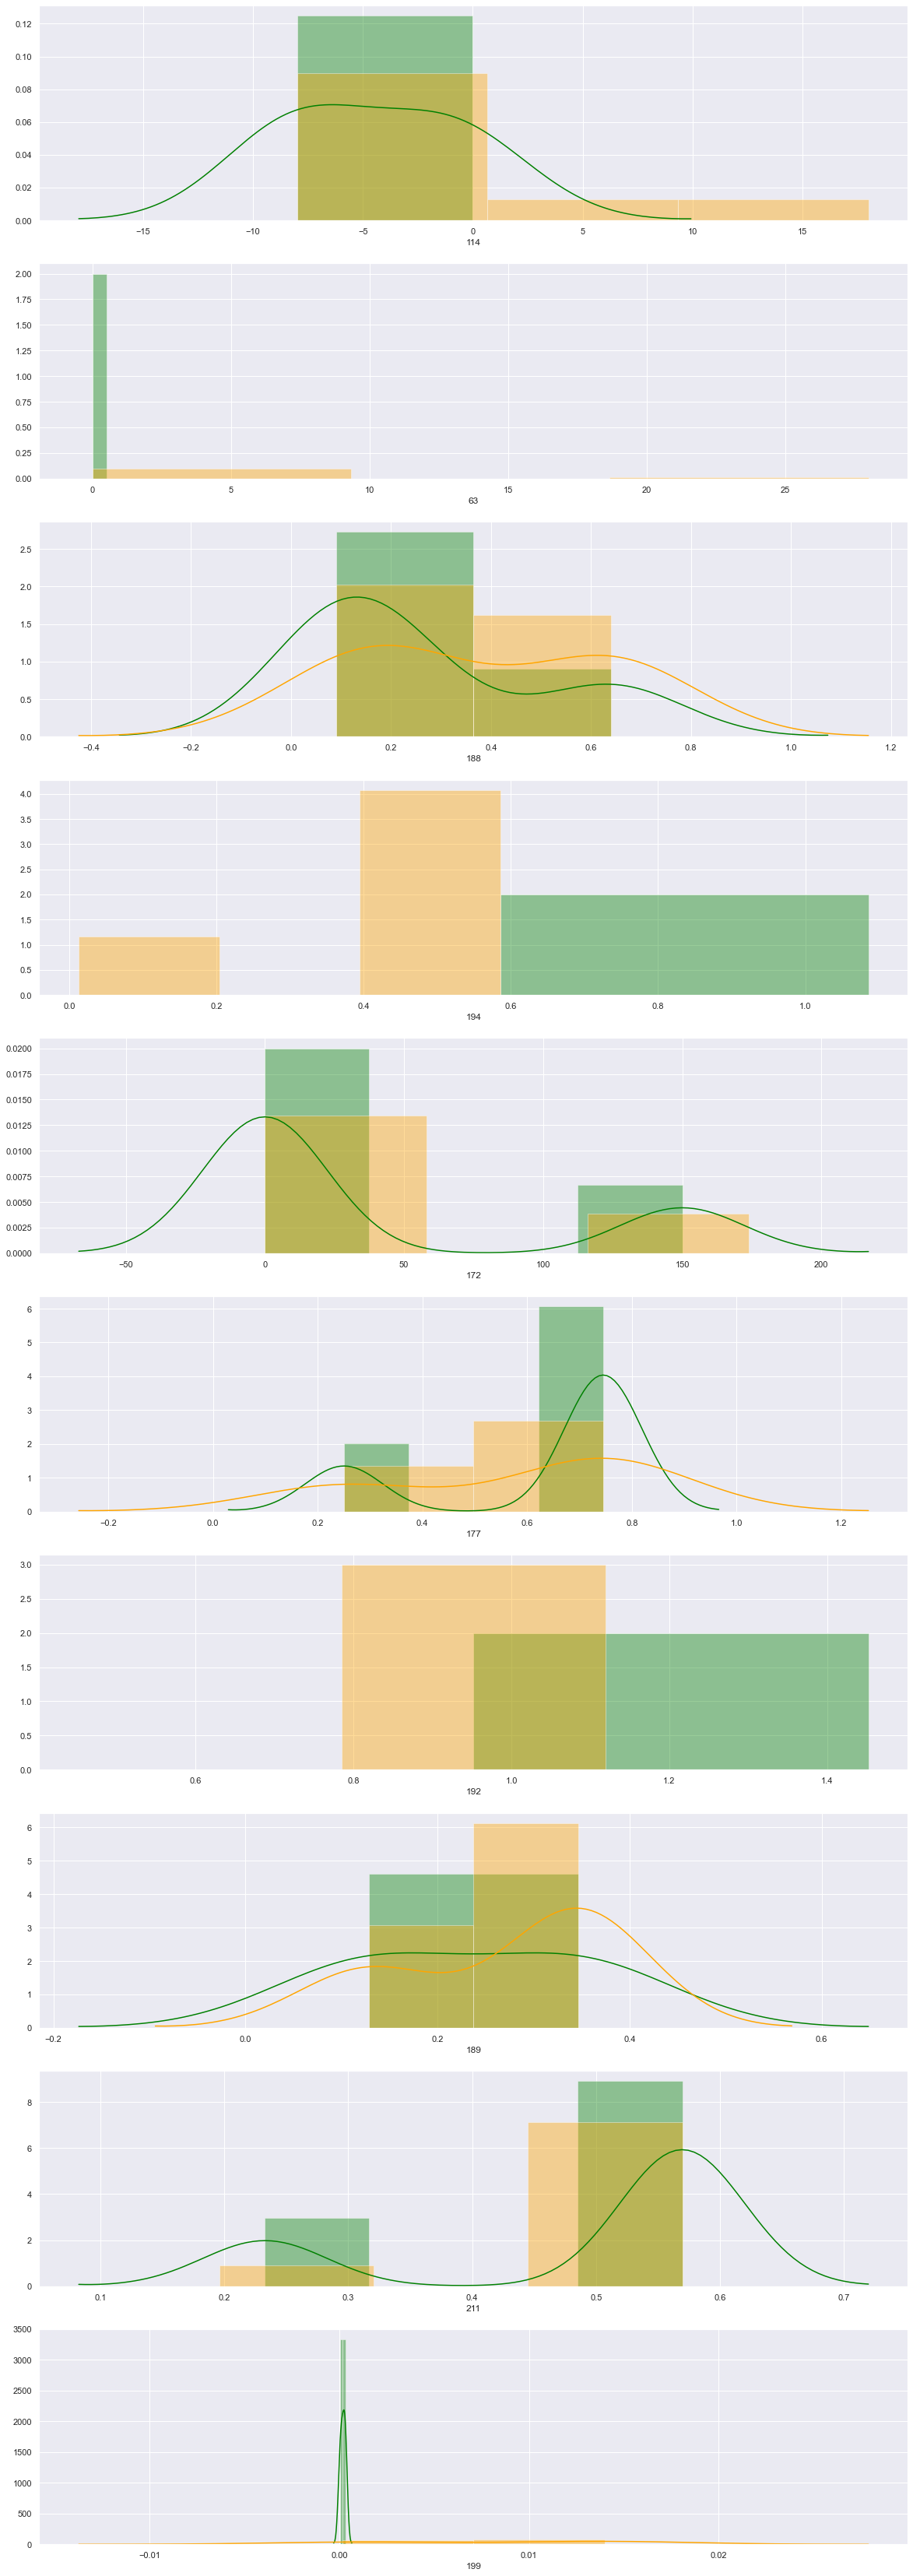

In [104]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs,  important_features.iloc[:10,1]):
    sns.distplot(first_type_err[column][data_with_predict['labels'] == 1], ax = ax, color = "green", label = str(column)+" Label = 1")
    sns.distplot(second_type_err[column][data_with_predict['labels'] == -1], ax = ax, color = "orange", label = str(column)+" Label = -1")

Wall time: 589 ms


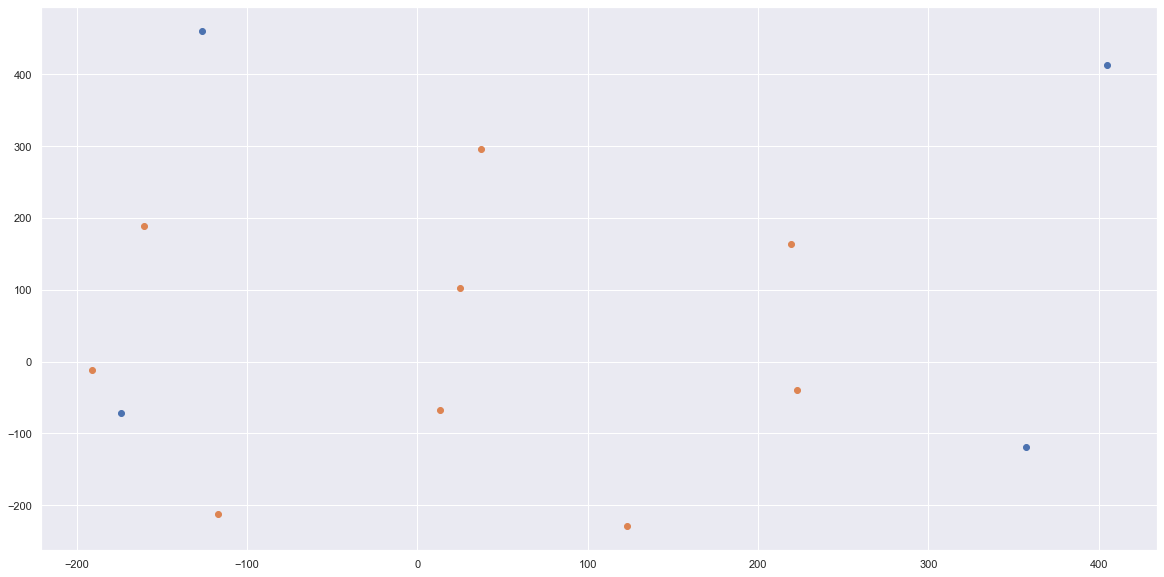

In [113]:
%%time
tsne = manifold.TSNE(random_state=17)
tsne_representation = tsne.fit_transform(first_type_err[important_features['labels'][:10]])
fig = plt.figure(figsize=(20,10))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]
            #, c=first_type_err['labels'].map({-1: 'blue', 1: 'orange'})
           );
tsne_representation = tsne.fit_transform(second_type_err[important_features['labels'][:10]])
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]
            #, c=first_type_err['labels'].map({1: 'blue', -1: 'orange'})
           );

9\. Построем финальное решение - модель с наилучшим качеством. Укажим, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [106]:
## Пропуски заполнены нулями
## Категориальные данные закодированны частотами
## Отбор признаков до 40 дал прирост в несколько процентов
## C помощью градиентного поиска optuna были найдены лучшие параметры XGBoost-a
## Оценку делаю с помощью F-меры
clf = XGBClassifier(n_estimators=trial.params['n_estimators'],
                    gamma=trial.params['gamma'],
                    learning_rate=trial.params['learning_rate'],
                    max_depth=trial.params['max_depth'],
                    colsample_bytree=trial.params['colsample_bytree'],
                    reg_lambda=trial.params['reg_lambda']
                                )

clf.fit(X_train_, y_train)

preds_class = clf.predict(X_test_)

f1 = f1_score(y_test, preds_class, average='macro')

print(f1)

0.4991141637007471


10\. Можно ли еще улучшить модель? Что для этого можно сделать? 

1. Посмотреть , как делают крутые люди и украсть у них идеи.
2. Делать композиции из моделей,записывать все данные в датафрейм и сравнивать результаты:
3. Сгенерировать новые фичи